In [1]:
import pandas as pd
from transformers import pipeline
from sklearn.metrics import classification_report, accuracy_score

# Load the CSV file
file_path = 'disneyland_reviews.csv'  # Replace with your actual file path
df = pd.read_csv(file_path, encoding="cp1252")

# Print the column names and 2 entries
print(df.columns)
print(df.head(2))

/Library/Python/3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


Index(['Review_ID', 'Rating', 'Year_Month', 'Reviewer_Location', 'Review_Text',
       'Branch'],
      dtype='object')
   Review_ID  Rating Year_Month Reviewer_Location  \
0  670772142       4     2019-4         Australia   
1  670682799       4     2019-5       Philippines   

                                         Review_Text               Branch  
0  If you've ever been to Disneyland anywhere you...  Disneyland_HongKong  
1  Its been a while since d last time we visit HK...  Disneyland_HongKong  


In [2]:
# Ensure the column containing reviews exists
review_column = 'Review_Text'  # Replace with the actual column name for reviews
rating_column = 'Rating'  # Replace with the actual column name for ratings
if review_column not in df.columns or rating_column not in df.columns:
    raise ValueError(f"Columns '{review_column}' and '{rating_column}' must be in the CSV file.")


df = df.dropna(subset=[review_column, rating_column])
print(df.head(2))

   Review_ID  Rating Year_Month Reviewer_Location  \
0  670772142       4     2019-4         Australia   
1  670682799       4     2019-5       Philippines   

                                         Review_Text               Branch  
0  If you've ever been to Disneyland anywhere you...  Disneyland_HongKong  
1  Its been a while since d last time we visit HK...  Disneyland_HongKong  


In [3]:
# Sanitize the review text
df[review_column] = df[review_column].str.replace('\n', ' ').str.replace('\r', ' ').str.strip()
print(df.head(2))

   Review_ID  Rating Year_Month Reviewer_Location  \
0  670772142       4     2019-4         Australia   
1  670682799       4     2019-5       Philippines   

                                         Review_Text               Branch  
0  If you've ever been to Disneyland anywhere you...  Disneyland_HongKong  
1  Its been a while since d last time we visit HK...  Disneyland_HongKong  


Rating ranges from 1 to 5.
Median rating: 3
Sentiment
POSITIVE    39030
NEGATIVE     3626
Name: count, dtype: int64


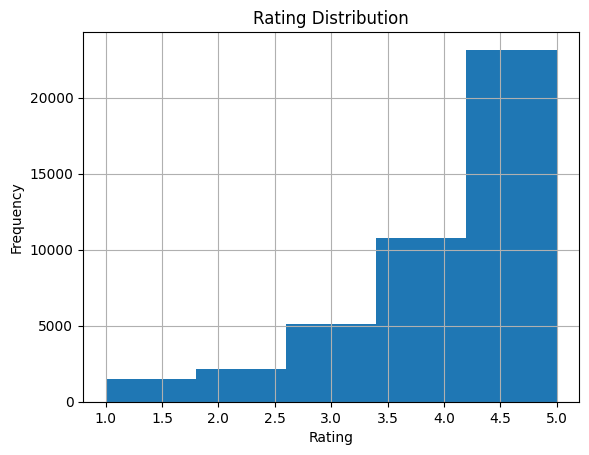

In [24]:
min_rating = df[rating_column].min()
max_rating = df[rating_column].max()
print(f"Rating ranges from {min_rating} to {max_rating}.")

# Define a threshold: Assume ratings >= 3 are POSITIVE, < 3 are NEGATIVE
median_rating = 3
df['Sentiment'] = df[rating_column].apply(lambda x: 'POSITIVE' if x >= median_rating else 'NEGATIVE')

# Print the distribution of sentiments
print(f"Median rating: {median_rating}")
print(df['Sentiment'].value_counts())

import matplotlib.pyplot as plt
df[rating_column].hist(bins=5)  # Adjust the number of bins if needed
plt.title("Rating Distribution")
plt.xlabel("Rating")
plt.ylabel("Frequency")
plt.show()

In [35]:
# %pip install tensorflow
# %pip install tf-keras
# %pip install tiktoken

# Initialize pipelines correctly for both models
distilbert_pipeline = pipeline("sentiment-analysis", model="./distilbert_finetuned_model")
deberta_pipeline = pipeline("sentiment-analysis", model="./deberta_finetuned_model")

label_mapping = {
    "LABEL_0": "NEGATIVE",
    "LABEL_1": "POSITIVE"
}

# Analyze sentiments function
def analyze_sentiments(pipeline, reviews):
    return [label_mapping[pipeline(review)[0]['label']] for review in reviews]

test_size = df.shape[0] * 0.2  # 20% of the data for testing
print(f"Testing on {test_size} samples.")

# Get reviews and true sentiment labels and stick to 20% rows for testing
reviews = df[review_column].tolist()[int(-test_size):]
true_labels = df['Sentiment'].tolist()[int(-test_size):]

# truncate reviews to 512 tokens
reviews = [review[:512] for review in reviews]

Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.
/Users/stefanmagirescu/Documents/master/SEM 1 sem 1/DMDW/code/.venv/lib/python3.9/site-packages/transformers/convert_slow_tokenizer.py:561: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(
Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.


Testing on 8531.2 samples.


In [36]:
# DistilBERT predictions
distilbert_predictions = analyze_sentiments(distilbert_pipeline, reviews)

In [37]:
# DeBERTa predictions
deberta_predictions = analyze_sentiments(deberta_pipeline, reviews)

In [38]:
# Step 6: Evaluate using scikit-learn metrics
print("DistilBERT Metrics:")
print(classification_report(true_labels, distilbert_predictions))
print(f"Accuracy: {accuracy_score(true_labels, distilbert_predictions):.4f}\n")

print("DeBERTa Metrics:")
print(classification_report(true_labels, deberta_predictions))
print(f"Accuracy: {accuracy_score(true_labels, deberta_predictions):.4f}\n")

# Save results to CSV for further analysis
shortened = pd.DataFrame({
    'True_Sentiment': true_labels,
    'DistilBERT_Sentiment': distilbert_predictions,
    'DeBERTa_Sentiment': deberta_predictions,
    'Review': reviews
})
shortened.to_csv("./sentiment_analysis_comparison.csv", index=False)
print("Results saved to sentiment_analysis_comparison.csv")

DistilBERT Metrics:
              precision    recall  f1-score   support

    NEGATIVE       0.76      0.63      0.69      1215
    POSITIVE       0.94      0.97      0.95      7316

    accuracy                           0.92      8531
   macro avg       0.85      0.80      0.82      8531
weighted avg       0.91      0.92      0.92      8531

Accuracy: 0.9192

DeBERTa Metrics:
              precision    recall  f1-score   support

    NEGATIVE       0.72      0.36      0.48      1215
    POSITIVE       0.90      0.98      0.94      7316

    accuracy                           0.89      8531
   macro avg       0.81      0.67      0.71      8531
weighted avg       0.88      0.89      0.87      8531

Accuracy: 0.8889

Results saved to sentiment_analysis_comparison.csv
